In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:09<00:00, 39.2MB/s]
100% 2.13G/2.13G [01:09<00:00, 32.7MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/leapgestrecog.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [5]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

data_path = "/content/leapGestRecog"

In [8]:
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 7, 5, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 6],
        [5, 6, 6, ..., 6, 6, 5],
        ...,
        [4, 5, 6, ..., 6, 5, 6],
        [5, 5, 5, ..., 4, 6, 5],
        [5, 5, 6, ..., 5, 5, 4]], dtype=uint8),
 0]

In [9]:
import random
random.shuffle(image_data)

In [10]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

In [11]:
label[:10]

[5, 2, 5, 4, 7, 6, 5, 4, 2, 4]

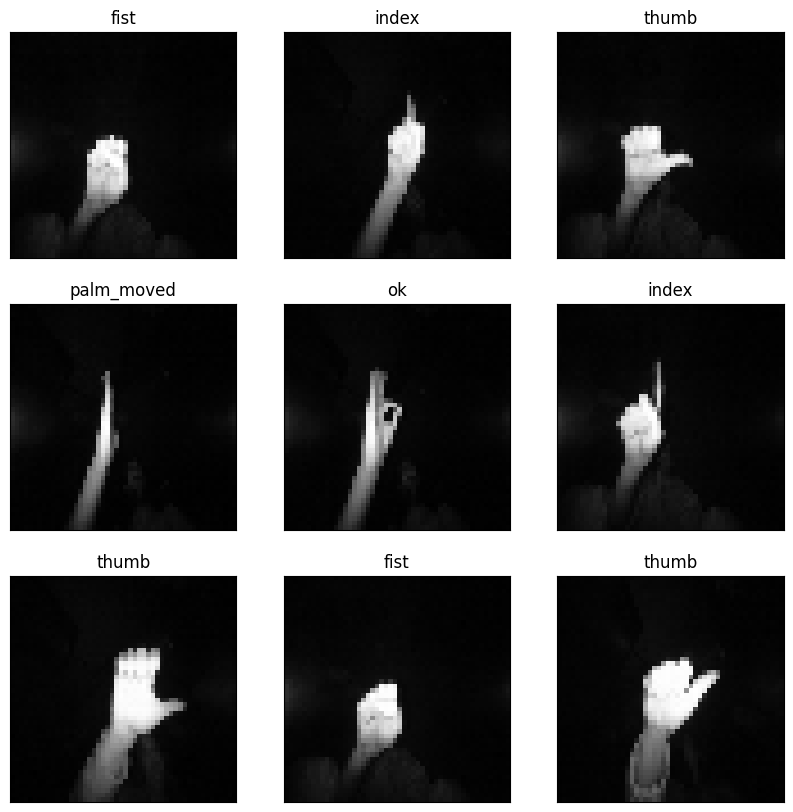

In [12]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [13]:
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [14]:
import keras
from keras.utils import to_categorical
label = to_categorical(label)

In [15]:
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label,test_size=0.2, random_state=42, shuffle=True)


In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16000, 50, 50, 1)
(4000, 50, 50, 1)
(16000, 10)
(4000, 10)


In [18]:
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))


model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])


In [19]:
history = model.fit(X_train, y_train, epochs =4, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/4
500/500 [==============================] - 132s 258ms/step - loss: 0.2223 - accuracy: 0.9321 - val_loss: 0.0066 - val_accuracy: 0.9983
Epoch 2/4
500/500 [==============================] - 122s 245ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 3/4
500/500 [==============================] - 127s 255ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 5.1674e-04 - val_accuracy: 0.9998
Epoch 4/4
500/500 [==============================] - 123s 246ms/step - loss: 9.5975e-04 - accuracy: 0.9998 - val_loss: 3.3969e-04 - val_accuracy: 1.0000


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                        

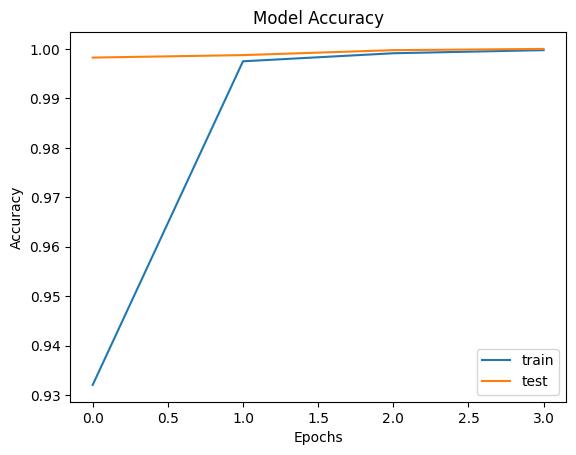

In [22]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

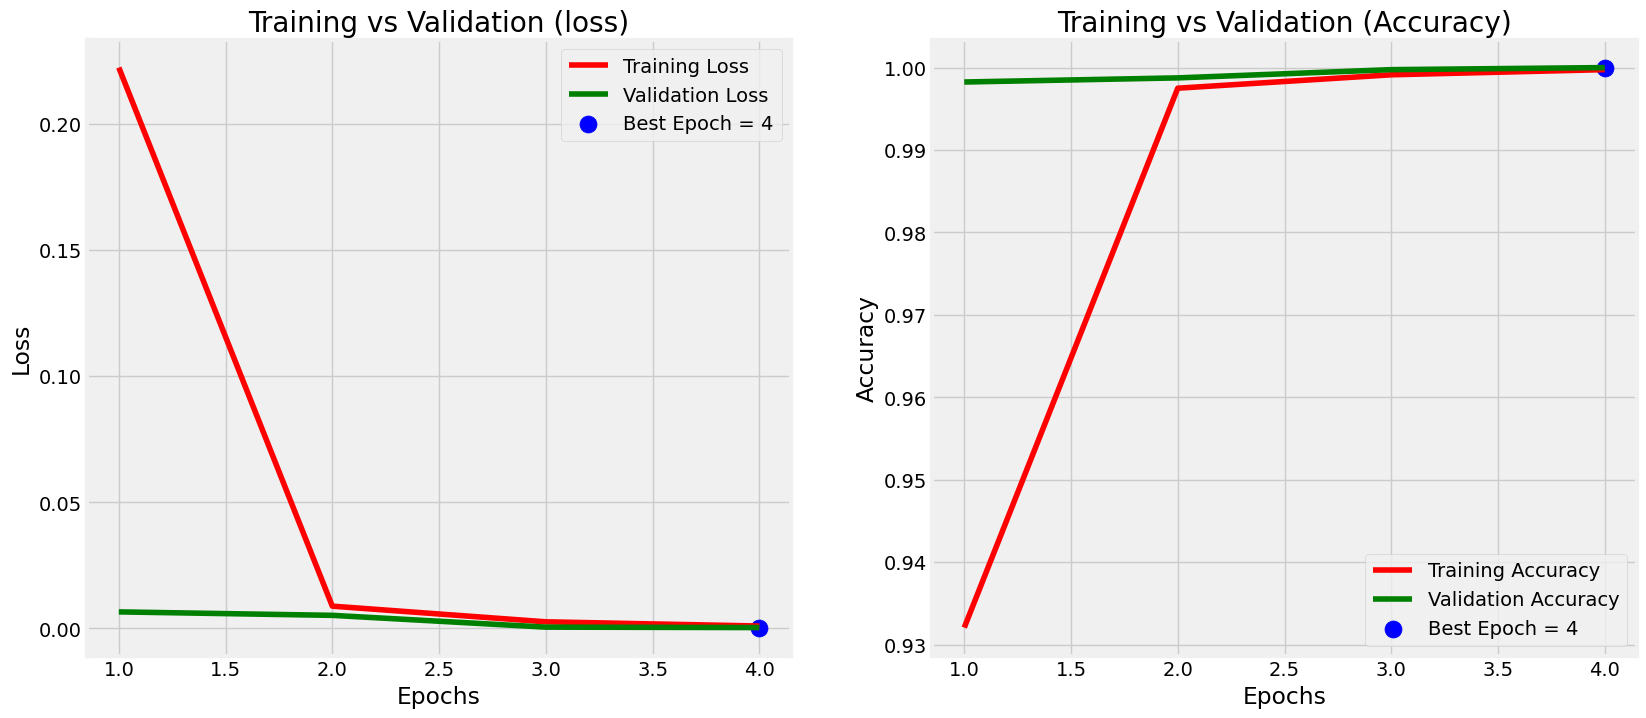

In [23]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

125/125 [==============================] - 9s 70ms/step - loss: 3.3969e-04 - accuracy: 1.0000
Test accuracy: 100.00%
